In [1]:
%load_ext autoreload
%autoreload 2
from utils.KMeans import *
from openml.datasets import list_datasets, get_datasets
import pandas as pd
import warnings
import json
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.datasets import make_blobs
import gc
from utils.helpers import load_datasets, clean_dataset
from matplotlib import rc
import matplotlib.pylab as plt
import matplotlib 
# matplotlib.rcParams['font.family'] = 'serif'
# matplotlib.rcParams['font.serif'] = ['Computer Modern']

# # Set Latex font
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)


In [2]:
%load_ext autoreload
%autoreload 2
from utils.helpers import extend_df, extend_array, generate_clusters, timeseries_plot, load_datasets, generate_complex_datasets, estimate_optimal_centroids, load_downloaded_datasets, agg_and_plot, fit_linear_regression, find_bad_initalization, addScatterPlot
from utils.KMeans import KMeans, getLables, getCentroids, getAvgDist, KMeans_sketching
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.cluster import KMeans as KMeans_sk
import pickle
from time import process_time_ns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Plot (ratio,k)

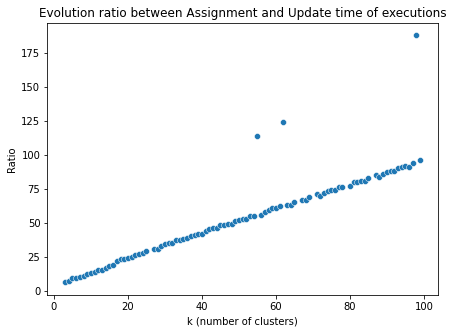

In [7]:
# Import dataset    
df = pd.read_csv('./data/measurements_1_1.csv')
# Compute ratio
df['ratio_AB_median'] = df['t_A_median']/df['t_B_median']
# Clean dataset
df_clean = clean_dataset(df)

# Plot

# Scatterplot
fig, ax = plt.subplots(figsize = (7,5))
sns.scatterplot(data=df_clean, x='n_clusters', y='ratio_AB_median', ax = ax)
ax.set_xlabel('k (number of clusters)')
ax.set_ylabel('Ratio')
ax.set_title('Evolution ratio between Assignment and Update time of executions')

fig.savefig("./figures_svg/plots_report/figure_section_1.svg", format="svg", bbox_inches='tight')

# 2. Plot Speculative vs. Vanilla K-means

In [6]:
# load datasets
query = "NumberOfInstances > 10000 &\
         NumberOfInstances < 100000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list, meta = load_datasets(query, n_datasets = 10, search = True, return_meta=True)

## 2.1 Run without trace

In [107]:
# Set parameter
seed = 0
np.random.seed(seed)
k = 8
num_iter = 50
subsample_size = 0.01
tol = 0

# Create dataset
dataset_index = 0
X = X_list[dataset_index]
n, d = X.shape

# Set output path
path = './data/report/vanilla_speculation_comparison.csv'

# Compute optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Compute initial centroids
np.random.seed(seed)
initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)

# Speculative K-means execution
labels, centroids = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, save=True, path=path, measure=True, choose_best=True, resampling=True, trace=False, tol=tol, resample_centroid=False, centroids=initial_centroids)

# Read .csv
df = pd.read_csv(path)

# Extend df to have num_iter rows
df = extend_df(df, num_iter)

# Define inertia_speculation
df['inertia_speculation'] = df[['L_slow', 'L_fast']].min(axis=1)

# Estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Add L_opt
df['inertia_optimal'] = getAvgDist(X, opt_centroids)

# Add Vanilla K-means execution
_, _, inertia_basic = KMeans(X, k, num_iter=num_iter, seed=seed, tol=tol, centroids=initial_centroids, measure_inertia=True)
df['inertia_vanilla'] = extend_array(inertia_basic, num_iter)

# Add K-means++ execution
_, _, inertia_pp = KMeans(X, k, num_iter=num_iter, seed=seed, tol = tol, kmeans_pp = True, measure_inertia=True)
df['inertia_pp'] = extend_array(inertia_pp, num_iter)

df.to_csv(path, index=False)

https://www.openml.org/d/23395
The dataset used is an ARFF dataset called COMET_MC_SAMPLE, version 2, uploaded on April 22nd, 2016. It is publicly available and can be downloaded from the URL provided. It contains 6 features and 89640 instances, and can be found on OpenML with the ID 23395.

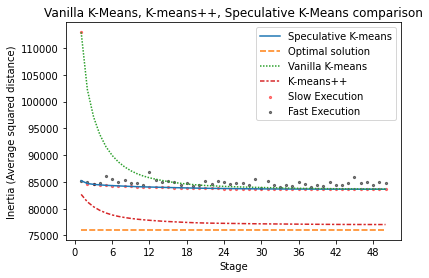

In [8]:
path = './data/report/vanilla_speculation_comparison.csv'

# import df
df = pd.read_csv(path)

# Timeseries plot
fig, ax = plt.subplots()
df = df.rename(columns={"inertia_speculation": "Speculative K-means", "inertia_optimal": "Optimal solution", "inertia_vanilla":"Vanilla K-means", "inertia_pp":"K-means++"})
timeseries_plot(df[['Speculative K-means', 'Optimal solution', 'Vanilla K-means', 'K-means++']], xlabel='Stage', ylabel='Inertia (Average squared distance)', title = 'Vanilla K-Means, K-means++, Speculative K-Means comparison', ax = ax, show = False)
addScatterPlot(ax, df['L_slow'], 'red', 'Slow Execution', size = 5)
addScatterPlot(ax, df['L_fast'], 'black', 'Fast Execution', size = 5)

# plt.savefig("plot_1.svg", format="svg", bbox_inches='tight')
plt.savefig("./figures_svg/plots_report/figure_section_2_1.svg", format="svg", bbox_inches='tight')
# meta[dataset_index]

## 2.2 Run with trace

In [116]:
# Set parameter
seed = 0
np.random.seed(seed)
k = 8
num_iter = 50
subsample_size = 0.01
tol = 0

# Create dataset
dataset_index = 0
X = X_list[dataset_index]
n, d = X.shape

# Set output path
path = './data/report/vanilla_speculation_comparison_trace.csv'

# Compute optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Compute initial centroids
np.random.seed(seed)
initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)

# Speculation execution
labels, centroids = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, save=True, path=path, measure=True, choose_best=True, resampling=True, trace=True, tol=tol, resample_centroid=False, centroids=initial_centroids, p = 0.5, q = 0.5)

# Read .csv
df = pd.read_csv(path)

# Extend df to have num_iter rows
df = extend_df(df, num_iter)

# Define inertia_speculation
df['inertia_speculation'] = df[['L_slow', 'L_fast']].min(axis=1)

# Estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Add L_opt
df['inertia_optimal'] = getAvgDist(X, opt_centroids)

# Add basic execution
_, _, inertia_basic = KMeans(X, k, num_iter=num_iter, seed=seed, tol=tol, centroids=initial_centroids, measure_inertia=True)
df['inertia_vanilla'] = extend_array(inertia_basic, num_iter)

# Add K-means++ execution
_, _, inertia_pp = KMeans(X, k, num_iter=num_iter, seed=seed, tol=tol, kmeans_pp = True, measure_inertia=True)
df['inertia_pp'] = extend_array(inertia_pp, num_iter)

df.to_csv(path, index=False)

https://www.openml.org/d/23395
The dataset used is an ARFF dataset called COMET_MC_SAMPLE, version 2, uploaded on April 22nd, 2016. It is publicly available and can be downloaded from the URL provided. It contains 6 features and 89640 instances, and can be found on OpenML with the ID 23395.

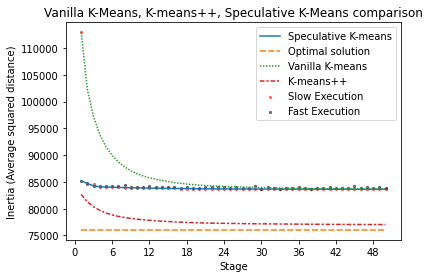

In [12]:
path = './data/report/vanilla_speculation_comparison_trace.csv'

# import df
df = pd.read_csv(path)

# Timeseries plot
fig, ax = plt.subplots()
df = df.rename(columns={"inertia_speculation": "Speculative K-means", "inertia_optimal": "Optimal solution", "inertia_vanilla":"Vanilla K-means", "inertia_pp":"K-means++"})
timeseries_plot(df[['Speculative K-means', 'Optimal solution', 'Vanilla K-means', 'K-means++']], xlabel='Stage', ylabel='Inertia (Average squared distance)', title = 'Vanilla K-Means, K-means++, Speculative K-Means comparison', ax = ax, show = False)
addScatterPlot(ax, df['L_slow'], 'red', 'Slow Execution', size = 5)
addScatterPlot(ax, df['L_fast'], 'black', 'Fast Execution', size = 5)
plt.savefig("./figures_svg/plots_report/figure_section_2_2.svg", format="svg", bbox_inches='tight')
#meta[dataset_index]

## 2.3 Resampling centroids 

In [33]:
# Set parameter
seed = 0
np.random.seed(seed)
k = 8
num_iter = 50
subsample_size = 0.01
tol = 0

# Create dataset
dataset_index = 0
X = X_list[dataset_index]
n, d = X.shape

# Set output path
path = './data/report/vanilla_speculation_comparison_resampling.csv'

# Compute optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Compute initial centroids
np.random.seed(seed)
initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)

# Speculation execution
labels, centroids = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, save=True, path=path, measure=True, choose_best=True, resampling=True, trace=False, tol=tol, resample_centroid=True, centroids=initial_centroids, p = 0.8, q = 0.5)

# Read .csv
df = pd.read_csv(path)

# Extend df to have num_iter rows
df = extend_df(df, num_iter)

# Define inertia_speculation
df['inertia_speculation'] = df[['L_slow', 'L_fast']].min(axis=1)

# Estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Add L_opt
df['inertia_optimal'] = getAvgDist(X, opt_centroids)

# Add basic execution
_, _, inertia_basic = KMeans(X, k, num_iter=num_iter, seed=seed, tol=tol, centroids=initial_centroids, measure_inertia=True)
df['inertia_vanilla'] = extend_array(inertia_basic, num_iter)

# Add K-means++ execution
_, _, inertia_pp = KMeans(X, k, num_iter=num_iter, seed=seed, tol=tol, kmeans_pp = True, measure_inertia=True)
df['inertia_pp'] = extend_array(inertia_pp, num_iter)

df.to_csv(path, index=False)

https://www.openml.org/d/23395
The dataset used is an ARFF dataset called COMET_MC_SAMPLE, version 2, uploaded on April 22nd, 2016. It is publicly available and can be downloaded from the URL provided. It contains 6 features and 89640 instances, and can be found on OpenML with the ID 23395.

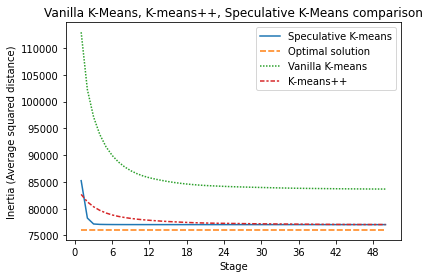

In [13]:
path = './data/report/vanilla_speculation_comparison_resampling.csv'

# import df
df = pd.read_csv(path)

# Timeseries plot
fig, ax = plt.subplots()
df = df.rename(columns={"inertia_speculation": "Speculative K-means", "inertia_optimal": "Optimal solution", "inertia_vanilla":"Vanilla K-means", "inertia_pp":"K-means++"})
timeseries_plot(df[['Speculative K-means', 'Optimal solution', 'Vanilla K-means', 'K-means++']], xlabel='Stage', ylabel='Inertia (Average squared distance)', title = 'Vanilla K-Means, K-means++, Speculative K-Means comparison', ax = ax, show = False)
# addScatterPlot(ax, df['L_slow'], 'red', 'Slow Execution', size = 5)
# addScatterPlot(ax, df['L_fast'], 'black', 'Fast Execution', size = 5)
# plt.savefig("plot_2.svg", format="svg", bbox_inches='tight')
plt.savefig("./figures_svg/plots_report/figure_section_2_3.svg", format="svg", bbox_inches='tight')
#meta[dataset_index]

# 3. Histogram reduced number of steps

❗Query different from before!

In [14]:
# load datasets
query = "NumberOfInstances > 500000 &\
         NumberOfInstances < 10000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list, meta = load_datasets(query, n_datasets = 10, search = True, return_meta=True)

In [15]:
meta

[OpenML Dataset
 Name..........: COMET_MC
 Version.......: 1
 Format........: ARFF
 Upload Date...: 2016-03-17 12:30:24
 Licence.......: CC_BY-SA
 Download URL..: https://api.openml.org/data/v1/download/1835237/COMET_MC.arff
 OpenML URL....: https://www.openml.org/d/5587
 # of features.: 6
 # of instances: 7619400,
 OpenML Dataset
 Name..........: French-Motor-Claims-Datasets-freMTPL2freq
 Version.......: 1
 Format........: arff
 Upload Date...: 2022-03-24 00:32:44
 Licence.......: GPL 2
 Download URL..: https://api.openml.org/data/v1/download/22102418/French-Motor-Claims-Datasets-freMTPL2freq.arff
 OpenML URL....: https://www.openml.org/d/43593
 # of features.: 12
 # of instances: 678013,
 OpenML Dataset
 Name..........: Radar-Traffic-Data
 Version.......: 1
 Format........: arff
 Upload Date...: 2022-03-23 12:35:19
 Licence.......: CC0: Public Domain
 Download URL..: https://api.openml.org/data/v1/download/22102179/Radar-Traffic-Data.arff
 OpenML URL....: https://www.openml.org/d/433

In [ ]:
# Set seed
seed = 0
subsample_size = 0.01
run = True
num_iter = 50
tol = 1e-3
measurements = []

# Real datasets
for i, X in enumerate(X_list):
    # Set parameters
    n, d = X.shape
    print(f'\nDataset {i}°:', end ="")
    for j, k in enumerate(range(3,11)):
        print(f' {k}', end = "")
        
        # Compute initial centroids
        np.random.seed(seed)
        initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)
              
        path = f'./data/report/histogram_steps_vanilla_id_{i}_k_{k}.csv'

        # Vanilla K-Means
        _, centroids_vanilla, steps_vanilla = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, save=True, path=path, measure=True, choose_best=False, tol=tol, centroids=initial_centroids, return_steps = True)
        inertia_vanilla = getAvgDist(X, centroids_vanilla)

        path = f'./data/report/histogram_steps_speculative_id_{i}_k_{k}.csv'
        # Speculative K-Means
        _, centroids_speculation, steps_speculation = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, return_steps = True, save=True, path=path, measure=True, choose_best=True, resampling=True, trace=True, tol=tol, resample_centroid=False, centroids=initial_centroids, p = 0.5, q = 0.5)
        inertia_speculation = getAvgDist(X, centroids_speculation)

        measurements.append({'n':n, 'd':d, 'k': k, 'i': i,'steps_vanilla':steps_vanilla, 'steps_speculation':steps_speculation, 'subsample_size':subsample_size, 'seed':seed, 'inertia_vanilla':inertia_vanilla, 'inertia_speculation':inertia_speculation})
        
# Save measurements to CSV file and compute ratio of steps for Speculative K-Means and Vanilla K-Means
df = pd.DataFrame(measurements)
df.to_csv('./data/report/histogram_steps.csv', index=False)

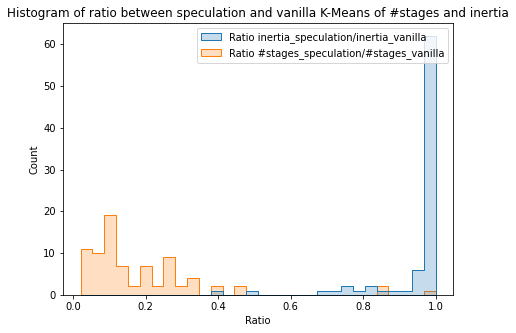

In [20]:
df = pd.read_csv('./data/report/histogram_steps.csv')
df['Ratio #stages_speculation/#stages_vanilla'] = df['steps_speculation'] / df['steps_vanilla']
df['Ratio inertia_speculation/inertia_vanilla'] = df['inertia_speculation'] / df['inertia_vanilla']

fig, ax = plt.subplots(figsize = (7,5))
sns.histplot(data=df[['Ratio inertia_speculation/inertia_vanilla', 'Ratio #stages_speculation/#stages_vanilla']], bins=30, element = 'step')
ax.set_xlabel('Ratio')
ax.set_ylabel('Count')
ax.set_title("Histogram of ratio between speculation and vanilla K-Means of #stages and inertia")
# plt.savefig("plot_3.svg", format="svg", bbox_inches='tight')
plt.savefig("./figures_svg/plots_report/figure_section_3.svg", format="svg", bbox_inches='tight')

# 4. Histogram escape local minima

In [7]:
# load datasets
query = "NumberOfInstances > 500000 &\
         NumberOfInstances < 10000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list, meta = load_datasets(query, n_datasets = 10, search = True, return_meta=True)

In [ ]:
# Set seed
seed = 0
subsample_size = 0.01
run = True
num_iter = 50
tol = 1e-3
measurements = []

# Real datasets
for i, X in enumerate(X_list):
    # Set parameters
    n, d = X.shape
    print(f'\nDataset {i}°:', end ="")
    for j, k in enumerate(range(3,11)):
        print(f' {k}', end = "")
        
        # Compute initial centroids
        np.random.seed(seed)
        initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)
              
        # Vanilla K-Means
        _, centroids_vanilla, steps_vanilla = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = False, tol = tol, centroids = initial_centroids, return_steps = True)
        inertia_vanilla = getAvgDist(X, centroids_vanilla)
        
        # K-Means++
        _, centroids_pp, steps_pp = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = True, tol = tol, return_steps = True)
        inertia_pp = getAvgDist(X, centroids_pp)
        
        # Speculative K-Means
        _, centroids_speculation, steps_speculation = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, choose_best=True, resampling=True, trace=False, tol=tol, resample_centroid=True, return_steps = True, centroids=initial_centroids, p = 0.5, q = 0.5)
        inertia_speculation = getAvgDist(X, centroids_speculation)
        
        # Estimate optimal inertia
        opt_centroids = estimate_optimal_centroids(X, k, seed=seed, n_init=50, tol=1e-6)
        inertia_optimal = getAvgDist(X, opt_centroids)
        
        measurements.append({'n':n, 'd':d, 'k': k, 'i': i, 'steps_vanilla':steps_vanilla, 'steps_speculation':steps_speculation, 'steps_pp': steps_pp, 'subsample_size':subsample_size, 'seed':seed, 'inertia_vanilla':inertia_vanilla, 'inertia_pp':inertia_pp, 'inertia_speculation':inertia_speculation, 'inertia_optimal':inertia_optimal})
        
# Save measurements to CSV file and compute ratio of steps for Speculative K-Means and Vanilla K-Means
df = pd.DataFrame(measurements)
df.to_csv('./data/report/histogram_escape_local_minima.csv', index=False)

## 4.1 Ratio Inertia

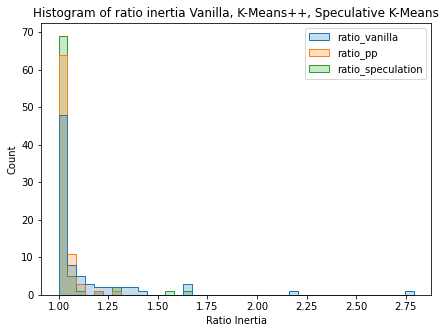

In [21]:
df = pd.read_csv('./data/report/histogram_escape_local_minima.csv')
df['ratio_vanilla'] = df['inertia_vanilla'] / df['inertia_optimal']
df['ratio_pp'] = df['inertia_pp'] / df['inertia_optimal']
df['ratio_speculation'] = df['inertia_speculation'] / df['inertia_optimal']

fig, ax = plt.subplots(figsize = (7,5))
sns.histplot(data=df[['ratio_vanilla', 'ratio_pp', 'ratio_speculation']], bins=40, element = 'step')
ax.set_xlabel('Ratio Inertia')
ax.set_ylabel('Count')
ax.set_title("Histogram of ratio inertia Vanilla, K-Means++, Speculative K-Means")
# plt.savefig("plot_4.svg", format="svg", bbox_inches='tight')
plt.savefig("./figures_svg/plots_report/figure_section_4_1.svg", format="svg", bbox_inches='tight')

## 4.2 Ratio #stages

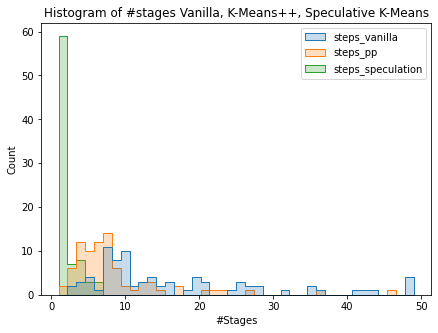

In [22]:
df = pd.read_csv('./data/report/histogram_escape_local_minima.csv')

fig, ax = plt.subplots(figsize = (7,5))
sns.histplot(data=df[['steps_vanilla', 'steps_pp','steps_speculation']], bins=40, element = 'step')
ax.set_xlabel('#Stages')
ax.set_ylabel('Count')
ax.set_title("Histogram of #stages Vanilla, K-Means++, Speculative K-Means")
#plt.savefig("plot_5.svg", format="svg", bbox_inches='tight')
plt.savefig("./figures_svg/plots_report/figure_section_4_2.svg", format="svg", bbox_inches='tight')

# 4 - bis. Histogram escape local minima

In this section we do the same study conducted in Section 4.

However we use **different datasets** to show that the previous datasets where not cherry-picked.

In [58]:
# Opening JSON file
f = open('datasets/datasets.json')
  
# load JSON containing all datasets information
datasets = json.load(f)

In [60]:
# Set seed
seed = 0
subsample_size = 0.01
run = True
num_iter = 50
tol = 1e-3
measurements = []

# Iterate over dataset types: 'A', 'Birtch', 'DIM', 'G2', 'S', 'Unbalance'
for dataset_type in datasets.keys():
    print(f'\nDataset type: {dataset_type}')
    # Extract data 
    X_list = [genfromtxt(d_, delimiter=',') for d_ in datasets[dataset_type]];
    for i, X in enumerate(X_list):
        # ignore datasets 1-d
        if len(X.shape) > 1:
            # Set parameters
            n, d = X.shape
            print(f'\n\tDataset {i}°:', end ="")
            for j, k in enumerate(range(3,11)):
                print(f' {k}', end = "")

                # Compute initial centroids
                np.random.seed(seed)
                initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)

                # Vanilla K-Means
                _, centroids_vanilla, steps_vanilla = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = False, tol = tol, centroids = initial_centroids, return_steps = True)
                inertia_vanilla = getAvgDist(X, centroids_vanilla)

                # K-Means++
                _, centroids_pp, steps_pp = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = True, tol = tol, return_steps = True)
                inertia_pp = getAvgDist(X, centroids_pp)

                # Speculative K-Means
                _, centroids_speculation, steps_speculation = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, choose_best=True, resampling=True, trace=False, tol=tol, resample_centroid=True, return_steps = True, centroids=initial_centroids, p = 0.5, q = 0.5)
                inertia_speculation = getAvgDist(X, centroids_speculation)

                # Estimate optimal inertia
                opt_centroids = estimate_optimal_centroids(X, k, seed=seed, n_init=50, tol=1e-6)
                inertia_optimal = getAvgDist(X, opt_centroids)

                measurements.append({'dataset_type':dataset_type, 'n':n, 'd':d, 'k': k, 'i': i, 'steps_vanilla':steps_vanilla, 'steps_speculation':steps_speculation, 'steps_pp': steps_pp, 'subsample_size':subsample_size, 'seed':seed, 'inertia_vanilla':inertia_vanilla, 'inertia_pp':inertia_pp, 'inertia_speculation':inertia_speculation, 'inertia_optimal':inertia_optimal})
    print('\n')   
# Save measurements to CSV file and compute ratio of steps for Speculative K-Means and Vanilla K-Means
df = pd.DataFrame(measurements)
df.to_csv('./data/report/histogram_escape_local_minima_bis.csv', index=False)


Dataset type: S

	Dataset 0°: 3 4 5 6 7 8 9 10
	Dataset 1°: 3 4 5 6 7 8 9 10
	Dataset 2°: 3 4 5 6 7 8 9 10
	Dataset 3°: 3 4 5 6 7 8 9 10


Dataset type: A

	Dataset 0°: 3 4 5 6 7 8 9 10
	Dataset 1°: 3 4 5 6 7 8 9 10
	Dataset 2°: 3 4 5 6 7 8 9 10


Dataset type: G2

	Dataset 10°: 3 4 5 6 7 8 9 10
	Dataset 11°: 3 4 5 6 7 8 9 10
	Dataset 12°: 3 4 5 6 7 8 9 10
	Dataset 13°: 3 4 5 6 7 8 9 10
	Dataset 14°: 3 4 5 6 7 8 9 10
	Dataset 15°: 3 4 5 6 7 8 9 10
	Dataset 16°: 3 4 5 6 7 8 9 10
	Dataset 17°: 3 4 5 6 7 8 9 10
	Dataset 18°: 3 4 5 6 7 8 9 10
	Dataset 19°: 3 4 5 6 7 8 9 10
	Dataset 20°: 3 4 5 6 7 8 9 10
	Dataset 21°: 3 4 5 6 7 8 9 10
	Dataset 22°: 3 4 5 6 7 8 9 10
	Dataset 23°: 3 4 5 6 7 8 9 10
	Dataset 24°: 3 4 5 6 7 8 9 10
	Dataset 25°: 3 4 5 6 7 8 9 10
	Dataset 26°: 3 4 5 6 7 8 9 10
	Dataset 27°: 3 4 5 6 7 8 9 10
	Dataset 28°: 3 4 5 6 7 8 9 10
	Dataset 29°: 3 4 5 6 7 8 9 10
	Dataset 30°: 3 4 5 6 7 8 9 10
	Dataset 31°: 3 4 5 6 7 8 9 10
	Dataset 32°: 3 4 5 6 7 8 9 10
	Dataset 33°: 3 4 5 

## 4.1 Histogram inertia

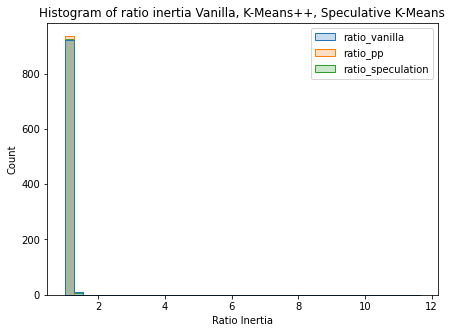

In [63]:
df = pd.read_csv('./data/report/histogram_escape_local_minima_bis.csv')
df['ratio_vanilla'] = df['inertia_vanilla'] / df['inertia_optimal']
df['ratio_pp'] = df['inertia_pp'] / df['inertia_optimal']
df['ratio_speculation'] = df['inertia_speculation'] / df['inertia_optimal']

fig, ax = plt.subplots(figsize = (7,5))
sns.histplot(data=df[['ratio_vanilla', 'ratio_pp', 'ratio_speculation']], bins=40, element = 'step')
ax.set_xlabel('Ratio Inertia')
ax.set_ylabel('Count')
ax.set_title("Histogram of ratio inertia Vanilla, K-Means++, Speculative K-Means")
plt.savefig("./figures_svg/plots_report/figure_section_4_1_bis.svg", format="svg", bbox_inches='tight')

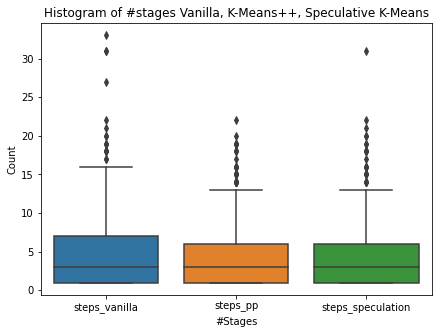

In [64]:
df = pd.read_csv('./data/report/histogram_escape_local_minima_bis.csv')


fig, ax = plt.subplots(figsize = (7,5))
# sns.histplot(data=df[df.dataset_type == 'S'][['steps_vanilla', 'steps_pp','steps_speculation']], bins=40, element = 'step')
sns.boxplot(data=df[['steps_vanilla', 'steps_pp','steps_speculation']])
ax.set_xlabel('#Stages')
ax.set_ylabel('Count')
ax.set_title("Histogram of #stages Vanilla, K-Means++, Speculative K-Means")
plt.savefig("./figures_svg/plots_report/figure_section_4_2_bis.svg", format="svg", bbox_inches='tight')

# 5. Adversarial datasets

We take as reference for finding complex datasets this page https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html, where performance of different clustering methods is compared on different datasets.

We will use the same datasets for measuring the performance of Speculative K-means:
- Concentric circles distributions
- Moon shaped (i.e: **not convex**) distributions
- Anisotropic distributions
- Gaussian distributions with different std for each cluster
- Simple Gaussian distributions
- Not structured distribution

In the following experiment, both Vanilla K-means and Speculative K-means **start from the same initial centroids**.

In [24]:
def measurements_complex_datasets(dataset_list, seed, k, num_iter, tol, subsample_size, p, q):
    results = []
    for i, dataset in enumerate(dataset_list):
        name = dataset['name']
        X, y = dataset['dataset']
        parameters = dataset['parameters']
        n, d = X.shape
        
        print(f'Dataset: {i}')
        
        # Compute initial centroids
        np.random.seed(seed)
        initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)

        # Vanilla K-means 
        labels, centroids, steps = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = False, tol = tol, centroids = initial_centroids, return_steps = True)
        results.append({'Dataset Type':name, 'Inertia' : getAvgDist(X, centroids), 'labels' : labels, 'dataset_index' : i, 'method': 'Vanilla K-means', 'Steps':steps})

        # K-Means++
        labels, centroids, steps = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = True, tol = tol, return_steps = True)
        results.append({'Dataset Type':name, 'Inertia' : getAvgDist(X, centroids), 'labels' : labels, 'dataset_index' : i, 'method': 'K-means++', 'Steps':steps})

        # Speculative K-means with centroid resampling
        labels, centroids, steps = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, choose_best=True, resampling=True, trace=False, tol=tol, resample_centroid=True, return_steps = True, centroids=initial_centroids, p = p, q = q)
        results.append({'Dataset Type':name, 'Inertia' : getAvgDist(X, centroids), 'labels' : labels, 'dataset_index' : i, 'method': 'Speculative K-means', 'Steps':steps})
    
    return results

In [43]:
def plot_performances_complex_datasets(df, n_samples, save = False, path = None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6))
    fig.suptitle(f'Inertia/#Steps Vanilla K-means, K-means++ Speculative K-means, n_datapoints = {n_samples}')
    sns.barplot(data=df, x="Dataset Type", y="Inertia", hue = "method", ax = ax1)
    sns.barplot(data=df, x="Dataset Type", y="Steps", hue = "method", ax = ax2)
    if save:
        fig.savefig(path, format="svg", bbox_inches='tight')

In [44]:
def plot_clustering(dataset_list, results, save = False, path = None):
    fig, axs = plt.subplots(len(dataset_list), 3, figsize = (12, 30))
    fig.suptitle('Clustering comparison - Vanilla K-means, K-means++, Speculative K-means', y = 0.9, fontsize = 16)
    for i, method in enumerate(['Vanilla K-means', 'K-means++', 'Speculative K-means']):
        specific_results = [result for result in results if result['method'] == method]
        for j, result in enumerate(specific_results):
            X = dataset_list[j]["dataset"][0]
            sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = result['labels'], ax = axs[j, i])
            axs[j, i].set_title(f'{dataset_list[j]["name"]} - {method}')
    if save:
        fig.savefig(path, format="svg")

In [31]:
# set parameters
run = True

In [ ]:
seed = 0
n_samples = 500000
k = 10
subsample_size = 0.01
num_iter = 50
tol = 1e-3
p = 0.5
q = 0.5

# generate datasets
dataset_list = generate_complex_datasets(n_samples = n_samples, seed = seed)

if run:
    # run measurements
    results = measurements_complex_datasets(dataset_list, seed=seed, k=k, num_iter=num_iter, tol=tol, subsample_size=subsample_size, p=p, q=q)

    df = pd.DataFrame(results)

    df.to_csv('./data/report/adversarial_datasets.csv', index=False)

## 5.1 Performance (inertia, #steps) with hard datasets

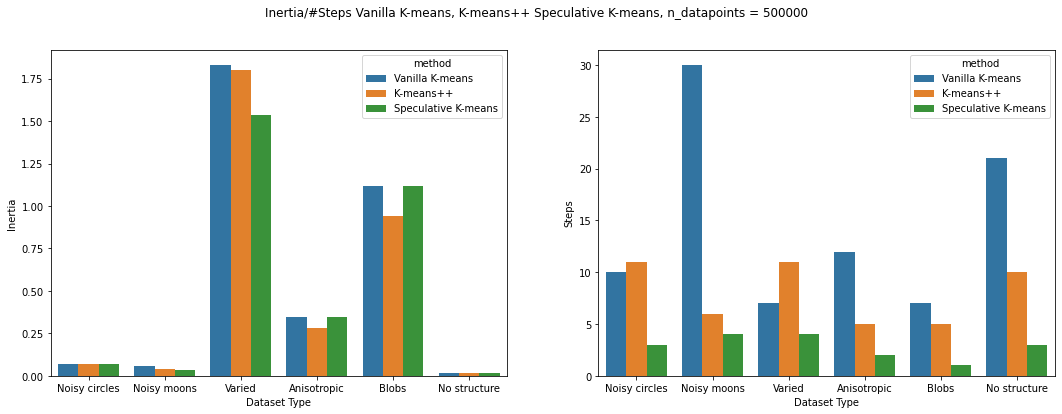

In [37]:
# read data
df = pd.read_csv('./data/report/adversarial_datasets.csv')

# plot performances
plot_performances_complex_datasets(df, n_samples, save = True, path = "./figures_svg/plots_report/figure_section_5_1.svg")

## 5.2 Visual comparison of clustering quality

In [65]:
# read data
df = pd.read_csv('./data/report/adversarial_datasets.csv')

# plot clusters
plot_clustering(dataset_list, results,  save = True, path = "./figures_svg/plots_report/figure_section_5_2.svg")

C:\Users\stefa\AppData\Local\Temp/ipykernel_21084/4219872401.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(path, format="svg")


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000210AE0114C0> (for post_execute):


KeyboardInterrupt: 

# 6. Increasing number of dimensions

In this section we aim to study the impact of the number of dimension of the dataset.

In particular, in high dimensions the datapoints are more sparse in the space (curse of dimensionality), which may lead to some problems when subsampling for the fast-execution.

We want therefore to see if high dimensions really impact on the performance and the accuracy of Speculative K-means.

In [3]:
def load_increasing_d_datasets(min_d, max_d, n_datasets, search, return_meta, dimensions = None):
    """ Return datasets from OpenML with increasing dimensions.
    
    min_d -- the minimum dimension
    max_d -- the maximum dimension
    n_datasets -- the number of datasets to retrieve
    search -- boolean if perform a new query at OpenML instead of using cashed datasets
    return_meta -- boolean if you want also the metadata describing the datasets
    
    Datasets have a minimum number of datapoints of 1'000.
    """
    
    # generate target dimensions to be found
    if dimensions is None:
        dimensions = np.linspace(min_d, max_d, n_datasets, dtype='int32')
    total_list = []
    if return_meta:
        total_meta = []
    print(f'Dimensions to be searched: {dimensions}')
    for i, d in enumerate(dimensions):
        while True:
            
            query = f"NumberOfInstances > 100000 &\
                      NumberOfNumericFeatures == {d} &\
                      NumberOfMissingValues == 0 &\
                      NumberOfSymbolicFeatures == 0"
            if return_meta:
                X_list, meta = load_datasets(query, n_datasets = 1, search = search, return_meta = return_meta)
            else:
                X_list = load_datasets(query, n_datasets = 1, search = search, return_meta = return_meta)
            if len(X_list)>0:
                print(f'\tDimension {d} found.')
                total_list.append(X_list[0])
                if return_meta:
                    total_meta.append(meta[0])
                break
            else:
                # try with d+1, and shift the remaining dimensions by +1
                print(f'\tDimension {d} not found.')
                d = d + 1
                # shift
                for j in range(i+1, len(dimensions)):
                    dimensions[j] = dimensions[j] + 1
    if return_meta:
        return total_list, total_meta
    return total_list

In [9]:
def measurements_increasing_d_datasets(X_list, seed, k, num_iter, tol, subsample_size, p, q):
    results = []
    for i, X in enumerate(X_list):
        n, d = X.shape
        
        print(f'Dataset: {i}')
        
        # Compute initial centroids
        np.random.seed(seed)
        initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)

        # Vanilla K-means 
        labels, centroids, steps = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = False, tol = tol, centroids = initial_centroids, return_steps = True)
        results.append({'Dimension' : d, 'Inertia' : getAvgDist(X, centroids)/(n*d), 'labels' : labels, 'dataset_index' : i, 'method': 'Vanilla K-means', 'Steps':steps})

        # K-Means++
        labels, centroids, steps = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = True, tol = tol, return_steps = True)
        results.append({'Dimension' : d, 'Inertia' : getAvgDist(X, centroids)/(n*d), 'labels' : labels, 'dataset_index' : i, 'method': 'K-means++', 'Steps':steps})

        # Speculative K-means with centroid resampling
        labels, centroids, steps = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, choose_best=True, resampling=True, trace=False, tol=tol, resample_centroid=True, return_steps = True, centroids=initial_centroids, p = p, q = q)
        
        results.append({'Dimension': d, 'Inertia' : getAvgDist(X, centroids)/(n*d), 'labels' : labels, 'dataset_index' : i, 'method': 'Speculative K-means', 'Steps':steps})
    
    return results

In [49]:
def plot_increasing_d_datasets(df, save = False, path = None):
    df['Steps'] = df['Steps'] + 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6))
    fig.suptitle(f'Inertia/#Steps Vanilla K-means, K-means++ Speculative K-means')
    sns.barplot(data=df, x="Dimension", y="Inertia", hue = "method", ax = ax1)
    sns.barplot(data=df, x="Dimension", y="Steps", hue = "method", ax = ax2)
    if save:
        fig.savefig(path, format="svg", bbox_inches='tight')

In [ ]:
# load datasets
query = "NumberOfInstances > 50000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list, meta = load_datasets(query, n_datasets = 30, search = True, return_meta=True)

In [ ]:
# set parameters
run = True

seed = 0
k = 5
subsample_size = 0.01
num_iter = 50
tol = 1e-3
p = 0.5
q = 0.5

# Opening JSON file
# f = open('datasets/datasets.json')
  
# load JSON containing all datasets
# datasets = json.load(f)

# load category DIM, containing datasets with increasing dimension, used for studying curse of dimensionality
# X_list = [genfromtxt(d_, delimiter=',') for d_ in datasets['DIM']];

if run:
    # run measurements
    results = measurements_increasing_d_datasets(X_list, seed=seed, k = k, num_iter=num_iter, tol=tol, subsample_size=subsample_size, p=p, q=q)

    df = pd.DataFrame(results)

    df.to_csv('./data/report/increasing_dimension.csv', index=False)

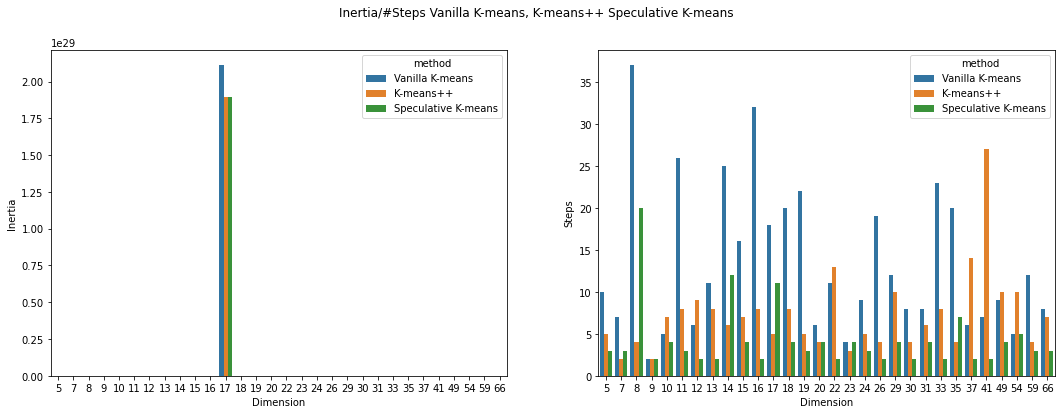

In [50]:
# read data
df = pd.read_csv('./data/report/increasing_dimension.csv')

# plot performances
plot_increasing_d_datasets(df, save = True, path = "./figures_svg/plots_report/figure_section_6.svg")

# 7. Sampling overhead

In [184]:
n = 100000000
x = np.arange(n)
k = 5

In [185]:
%%time
x = np.random.permutation(x)
print(f'First sample: {x[:k]}')
print(f'Second sample: {x[k:2*k]}')
print(f'Third sample: {x[2*k:3*k]}')

First sample: [14012627 22304571 21556383 16693736 80819237]
Second sample: [75975424 13856024 19513153 11614969 83794627]
Third sample: [27026105 66257653 32574766 82520678 60671449]
Wall time: 5.43 s


In [186]:
%%time
print(f'First sample: {x[np.random.choice(n, k, replace=False)]}')
print(f'Second sample: {x[np.random.choice(n, k, replace=False)]}')
print(f'Third sample: {x[np.random.choice(n, k, replace=False)]}')

First sample: [95518949 25354370 59264672 46371046 62987415]
Second sample: [76945409 85506438 61573269 63620932 21359620]
Third sample: [40711002 64836812 82602192 90737364 24030354]
Wall time: 16.3 s


# 8. Overall time execution

In [ ]:
# load datasets
query = "NumberOfInstances > 500000 &\
         NumberOfInstances < 10000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list, meta = load_datasets(query, n_datasets = 10, search = True, return_meta=True)

In [ ]:
# Set seed
seed = 0
subsample_size = 0.01
run = True
num_iter = 50
tol = 1e-3
measurements = []

# Real datasets
for i, X in enumerate(X_list):
    # Set parameters
    n, d = X.shape
    print(f'\nDataset {i}°:', end ="")
    for j, k in enumerate(range(3,11)):
        print(f' {k}', end = "")
        
        # Compute initial centroids
        np.random.seed(seed)
        initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)
              
        # Vanilla K-Means
        _, centroids_vanilla, t_A_array, t_B_array, steps_vanilla = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = False, tol = tol, centroids = initial_centroids, measure = True, return_steps = True)
        time_execution_vanilla = t_A_array.sum() + t_B_array.sum()
        inertia_vanilla = getAvgDist(X, centroids_vanilla)
        
        # Speculative K-Means
        path = f'./data/report/histogram_time_execution_id_{i}_k_{k}.csv'
        _, centroids_speculation, steps_speculation = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, save=True, path=path, measure=True, choose_best=True, resampling=True, trace=True, tol=tol, resample_centroid=False, measure_time = True,centroids=initial_centroids, p = 0.5, q = 0.5, return_steps = True)
        df_speculation = pd.read_csv(path)
        time_execution_speculation = df_speculation[['t_A', 't_B','t_sampling','t_choose_best','t_get_avg','t_permutation']].to_numpy().sum()
        inertia_speculation = getAvgDist(X, centroids_speculation)
        
        measurements.append({'n':n, 'd':d, 'k': k, 'i': i, 'time_execution_vanilla':time_execution_vanilla, 'time_execution_speculation':time_execution_speculation, 'subsample_size':subsample_size, 'seed':seed, 'steps_vanilla':steps_vanilla, 'steps_speculation':steps_speculation, 'inertia_vanilla':inertia_vanilla, 'inertia_speculation':inertia_speculation})
        
# Save measurements to CSV file and compute ratio of steps for Speculative K-Means and Vanilla K-Means
df = pd.DataFrame(measurements)
df.to_csv('./data/report/histogram_time_execution.csv', index=False)

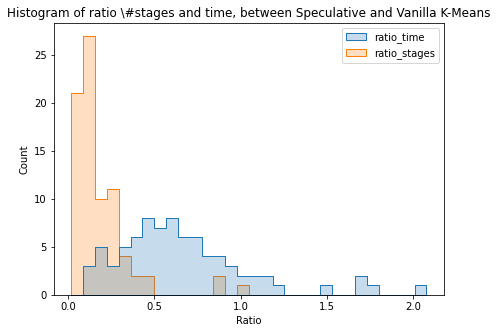

In [53]:
df = pd.read_csv('./data/report/histogram_time_execution.csv')
df['ratio_time'] = df['time_execution_speculation'] / df['time_execution_vanilla']
df['ratio_stages'] = df['steps_speculation'] / df['steps_vanilla']

fig, ax = plt.subplots(figsize = (7,5))
sns.histplot(data=df[['ratio_time','ratio_stages']], bins=30, element="step")
ax.set_xlabel('Ratio')
ax.set_ylabel('Count')
ax.set_title("Histogram of ratio \#stages and time, between Speculative and Vanilla K-Means")
fig.savefig("./figures_svg/plots_report/figure_section_8.svg", format="svg", bbox_inches='tight')